<a href="https://colab.research.google.com/github/fanroyi/E4511-2021-Fan/blob/main/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis

In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/


## Mount your drive where you have the Columbia_E4511 **folder**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Install packages** 

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-04-03 23:51:57--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   278MB/s    in 1.8s    

2021-04-03 23:51:59 (278 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


InvalidVersionSpec: Invalid version '4.19.112+': empty version component


real	0m8.137s
user	0m5.987s
sys	0m1.311s
--2021-04-03 23:58:25--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh’

install_AMPL_GPU_te 100%[===================>]   1.07K

# Load Libraries

In [2]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# manipulate data
import pandas as pd

import json
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

In [5]:
! time conda install -c conda-forge -y mordred bravado molvs
! pip install bravado
! pip install molvs
! pip install umap


InvalidVersionSpec: Invalid version '4.19.112+': empty version component


real	0m6.984s
user	0m5.920s
sys	0m1.149s
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 133kB 18.9MB/s 
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=1a731e1cc3615550314ce7cc284b5dd63d00d96e20e76f2bac7c458fbf812ec2
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339
     |████████████████████████████████| 71kB 13.8MB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-cp37-none-any.whl size=32376 sha256=a5936946fefba0edb0b3daa05456b7e1cd99459d354fcb1d103b74d8ee0fad1e
  Stored in directory: /root/.cache/pip/wheels/30/37/a8/8ac8147605c9de6b45ffd66d1cc19761d41467db12b34a0de8
Successfully built molvs
  Created wheel for umap: filename=umap-0.1.1-cp37-none-any.whl size=3568 sha256=fe523643e25e80e3e61af6b71a2c70a9a4a1fe4995859a2d85

In [6]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

# Download/Load data

In [7]:
! wget https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/CYP2C9_DTC_SMILES.csv
! wget https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/CYP2C9_Excape_SMILES.csv
! wget https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/CYP2C9_ChEMBL_SMILES.csv

--2021-04-04 00:09:31--  https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/CYP2C9_DTC_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105678 (103K) [text/plain]
Saving to: ‘CYP2C9_DTC_SMILES.csv’

CYP2C9_DTC_SMILES.c 100%[===================>] 103.20K  --.-KB/s    in 0.008s  

2021-04-04 00:09:32 (13.0 MB/s) - ‘CYP2C9_DTC_SMILES.csv’ saved [105678/105678]

--2021-04-04 00:09:32--  https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/CYP2C9_Excape_SMILES.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

# Explore and examine **data**

In [44]:
dtc = pd.read_csv("CYP2C9_DTC_SMILES.csv",header=0 )
excape = pd.read_csv("CYP2C9_Excape_SMILES.csv",header=0)
chembl = pd.read_csv("CYP2C9_ChEMBL_SMILES.csv",header=0)

# DTC Curation

In [46]:
dtc=dtc.drop(columns=dtc.iloc[:,0:1])


In [65]:
dtc.shape

(226, 36)

In [48]:
new_dtc = dtc[['compound_id','standard_inchi_key','standard_type','standard_relation',
       'standard_value', 'standard_units','pDTC_Value', 'SMILES', 'base_rdkit_smiles']]
new_dtc

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL3262143,ABWJEIIFONCFKT-UHFFFAOYSA-N,INHIBITION,=,28.0,%,28.000000,C1CN(C(CN1)COC2=CN=CC=C2)C3=NC4=C(C=CC=C4S3)F.Cl,Fc1cccc2sc(N3CCNCC3COc3cccnc3)nc12
1,CHEMBL2087450,AEZVYNVHNCDBQX-UHFFFAOYSA-N,INHIBITION,=,11.0,%,11.000000,C1CCN(CC1)CCCCC(=O)NC2=NNC(=C2)C3=CC=C(C=C3)C(...,O=C(CCCCN1CCCCC1)Nc1cc(-c2ccc(C(F)(F)F)cc2)[nH]n1
2,CHEMBL1643880,AFUWQWYPPZFWCO-LBPRGKRZSA-N,IC50,<,10000.0,NM,5.000000,C1CN2CCC1[C@H](C2)NC(=O)C3=CNC4=C(C3=O)SC=C4,O=C(N[C@H]1CN2CCC1CC2)c1c[nH]c2ccsc2c1=O
3,CHEMBL399045,AKKGFQRBBVGLEB-KRXBUXKQSA-N,IC50,>,40000.0,NM,4.397940,C1CN(CCC1CN2CCC(CC2)C3=CC=C(C=C3)Cl)C(=O)/C=C/...,O=C(/C=C/c1ccc(Cl)c(Cl)c1)N1CCC(CN2CCC(c3ccc(C...
4,CHEMBL68131,AOOSJYIINXVNHV-UHFFFAOYSA-N,AC50,NaN,NaN,NaN,NaN,CCCCN1CCC(CC1)COC(=O)C2=CC(=C(C3=C2OCCO3)N)Cl,CCCCN1CCC(COC(=O)c2cc(Cl)c(N)c3c2OCCO3)CC1
...,...,...,...,...,...,...,...,...,...
221,CHEMBL56564,ZNRGQMMCGHDTEI-ITGUQSILSA-N,KI,NaN,NaN,NaN,NaN,CN1[C@@H]2CC[C@H]1CC(C2)OC(=O)C3=CNC4=CC=CC=C43,CN1[C@H]2CC[C@@H]1CC(OC(=O)c1c[nH]c3ccccc13)C2
222,CHEMBL1651219,ZQBPXBADOJMCRU-UHFFFAOYSA-N,IC50,=,4000.0,NM,5.397940,C1CCC(C1)N2C(=O)C3=C(S2)C=C(C=C3)OCC4=CC(=CC=C...,O=C(O)c1cc(-c2cccc(COc3ccc4c(=O)n(C5CCCC5)sc4c...
223,CHEMBL1651219,ZQBPXBADOJMCRU-UHFFFAOYSA-N,INHIBITION,=,93.0,%,93.000000,C1CCC(C1)N2C(=O)C3=C(S2)C=C(C=C3)OCC4=CC(=CC=C...,O=C(O)c1cc(-c2cccc(COc3ccc4c(=O)n(C5CCCC5)sc4c...
224,CHEMBL3262132,ZWCUBSOPHPGVRD-UTONKHPSSA-N,INHIBITION,=,22.0,%,22.000000,C1CN([C@H](CN1)COC2=CN=CC=C2)C3=NC4=C(O3)C=CC=...,c1cncc(OC[C@H]2CNCCN2c2nc3ncccc3o2)c1


In [50]:
new_dtc.standard_type.value_counts()

INHIBITION         67
IC50               60
AC50               43
KI                 26
POTENCY            18
DRUG METABOLISM     5
ACTIVITY            5
T1/2                1
RATIO IC50          1
Name: standard_type, dtype: int64

In [53]:
print(sum(new_dtc['pDTC_Value'].isna()) )
print(len(new_dtc) - sum(new_dtc['pDTC_Value'].isna()))

len(dtc)

95
131


226

In [54]:
dset_dtc = new_dtc[~(new_dtc.standard_inchi_key.isna())  &
            (new_dtc.standard_units == 'NM') &
            ~new_dtc.standard_value.isna() &
            ~new_dtc.compound_id.isna() &
             (new_dtc.standard_relation == '=') &
             ~new_dtc.standard_relation.isna()]

In [55]:

dset_dtc = dset_dtc.loc[(new_dtc.standard_type == 'IC50') | (new_dtc.standard_type == 'EC50')]
dset_dtc

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pDTC_Value,SMILES,base_rdkit_smiles
14,CHEMBL2204363,CAVNQHZFZKMWIY-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,CC1=CC(=C(C=C1)SC2=CC=CC=C2N3CCNCC3)Cl.Cl,Cc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1
19,CHEMBL1082723,CKLPLPZSUQEDRT-WPCRTTGESA-N,IC50,=,5420.0,NM,5.266001,C[C@H]1CC2=C([C@]3(N1)C4=C(C=CC(=C4)Cl)NC3=O)N...,C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...
34,CHEMBL1651208,DWTYHCYVKJONSP-UHFFFAOYSA-N,IC50,=,8200.0,NM,5.086186,C1CCC(C1)N2CC3=C(C2=O)C=CC(=C3)OCC4=CC(=CC=C4)...,O=C(O)c1cc(-c2cccc(COc3ccc4c(c3)CN(C3CCCC3)C4=...
62,CHEMBL2204357,HHVBUSGGPUQAOP-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,CC1=C(C(=CC=C1)SC2=CC=CC=C2N3CCNCC3)C.Cl,Cc1cccc(Sc2ccccc2N2CCNCC2)c1C
70,CHEMBL2204360,JOJYHYRCIYAVHN-UHFFFAOYSA-N,IC50,=,39000.0,NM,4.408935,CC1=CC(=C(C=C1)SC2=CC=CC=C2N3CCNCC3)C.Cl,Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1
74,CHEMBL2204356,JTQUHGRGBNXQDN-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,C1CN(CCN1)C2=CC=CC=C2SC3=C(C(=CC=C3)Cl)Cl.Cl,Clc1cccc(Sc2ccccc2N2CCNCC2)c1Cl
145,CHEMBL42,QZUDBNBUXVUHMW-UHFFFAOYSA-N,IC50,=,21200.0,NM,4.673664,CN1CCN(CC1)C2=NC3=C(C=CC(=C3)Cl)NC4=CC=CC=C42,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1
160,CHEMBL50,REFJWTPEDVJJIY-UHFFFAOYSA-N,IC50,=,10200.0,NM,4.991400,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12
166,CHEMBL2204359,RJOWFEDJGNNCDF-UHFFFAOYSA-N,IC50,=,34000.0,NM,4.468521,C1CN(CCN1)C2=CC=CC=C2SC3=C(C=C(C=C3)Cl)Cl.Cl,Clc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1
184,CHEMBL2205045,TYKBKDLIAKRVRZ-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,CC1=CC=C(C=C1)SC2=CC=CC=C2N3CCNCC3.Cl,Cc1ccc(Sc2ccccc2N2CCNCC2)cc1


In [56]:
sum(dset_dtc.base_rdkit_smiles.isna())

0

In [57]:
dset_dtc = dset_dtc.rename(columns={"pDTC_Value": "pXC50"})
dset_dtc.columns

Index(['compound_id', 'standard_inchi_key', 'standard_type',
       'standard_relation', 'standard_value', 'standard_units', 'pXC50',
       'SMILES', 'base_rdkit_smiles'],
      dtype='object')

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
dset_dtc.to_csv('drive/MyDrive/E4511-2021-Fan/DTC_DROP.csv')

Canonicalizing 13 molecules...
Done
Computing fingerprints...
Done
Computing MCS distance matrix...
1 incomplete MCS searches
Done
       compound_1     compound_2      dist  i   j
8   CHEMBL2204363  CHEMBL2205045  0.024390  0   9
70  CHEMBL2204359  CHEMBL2205043  0.024390  8  11
72  CHEMBL2205045  CHEMBL2205054  0.024390  9  10
46  CHEMBL2204360  CHEMBL2205045  0.024390  4   9
52  CHEMBL2204356  CHEMBL2204359  0.047619  5   8
47  CHEMBL2204360  CHEMBL2205054  0.047619  4  10
9   CHEMBL2204363  CHEMBL2205054  0.047619  0  10
39  CHEMBL2204357  CHEMBL2205054  0.047619  3  10
4   CHEMBL2204363  CHEMBL2204356  0.047619  0   5
3   CHEMBL2204363  CHEMBL2204360  0.047619  0   4


AttributeError: ignored

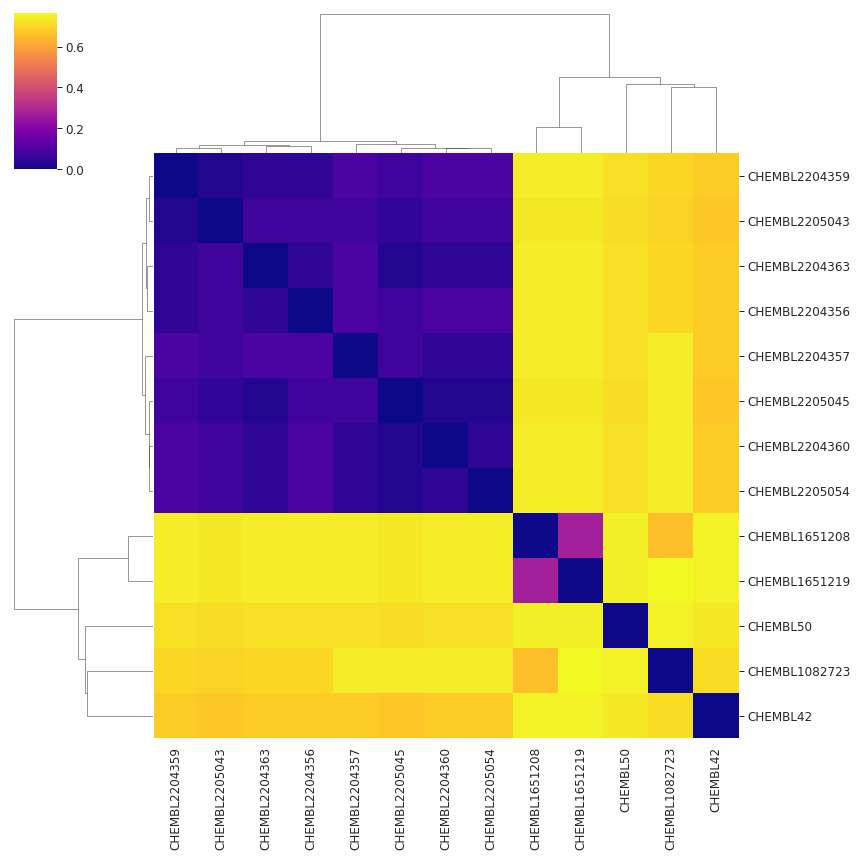

In [62]:
dp.diversity_plots(dset_key = 'drive/MyDrive/E4511-2021-Fan/DTC_DROP.csv',
                   datastore = False,
                   response_col = 'pXC50', smiles_col='base_rdkit_smiles',
                   max_for_mcs = 100)

In [63]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = dset_dtc['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

print(len(dist_sample))
print(len(smiles_lst1))

13
13


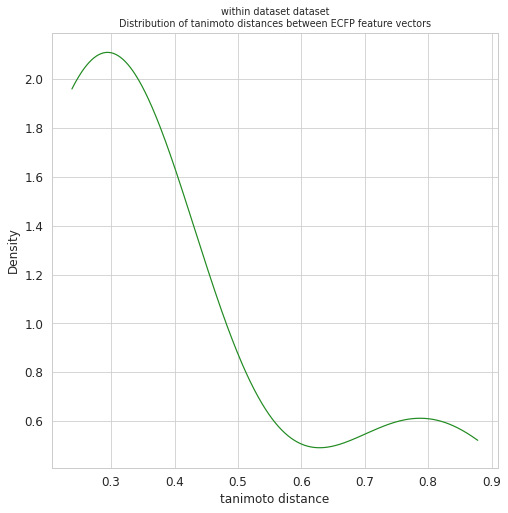

In [66]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [67]:
dset_dtc

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pXC50,SMILES,base_rdkit_smiles
14,CHEMBL2204363,CAVNQHZFZKMWIY-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,CC1=CC(=C(C=C1)SC2=CC=CC=C2N3CCNCC3)Cl.Cl,Cc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1
19,CHEMBL1082723,CKLPLPZSUQEDRT-WPCRTTGESA-N,IC50,=,5420.0,NM,5.266001,C[C@H]1CC2=C([C@]3(N1)C4=C(C=CC(=C4)Cl)NC3=O)N...,C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...
34,CHEMBL1651208,DWTYHCYVKJONSP-UHFFFAOYSA-N,IC50,=,8200.0,NM,5.086186,C1CCC(C1)N2CC3=C(C2=O)C=CC(=C3)OCC4=CC(=CC=C4)...,O=C(O)c1cc(-c2cccc(COc3ccc4c(c3)CN(C3CCCC3)C4=...
62,CHEMBL2204357,HHVBUSGGPUQAOP-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,CC1=C(C(=CC=C1)SC2=CC=CC=C2N3CCNCC3)C.Cl,Cc1cccc(Sc2ccccc2N2CCNCC2)c1C
70,CHEMBL2204360,JOJYHYRCIYAVHN-UHFFFAOYSA-N,IC50,=,39000.0,NM,4.408935,CC1=CC(=C(C=C1)SC2=CC=CC=C2N3CCNCC3)C.Cl,Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1
74,CHEMBL2204356,JTQUHGRGBNXQDN-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,C1CN(CCN1)C2=CC=CC=C2SC3=C(C(=CC=C3)Cl)Cl.Cl,Clc1cccc(Sc2ccccc2N2CCNCC2)c1Cl
145,CHEMBL42,QZUDBNBUXVUHMW-UHFFFAOYSA-N,IC50,=,21200.0,NM,4.673664,CN1CCN(CC1)C2=NC3=C(C=CC(=C3)Cl)NC4=CC=CC=C42,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1
160,CHEMBL50,REFJWTPEDVJJIY-UHFFFAOYSA-N,IC50,=,10200.0,NM,4.991400,C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O)O)O,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12
166,CHEMBL2204359,RJOWFEDJGNNCDF-UHFFFAOYSA-N,IC50,=,34000.0,NM,4.468521,C1CN(CCN1)C2=CC=CC=C2SC3=C(C=C(C=C3)Cl)Cl.Cl,Clc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1
184,CHEMBL2205045,TYKBKDLIAKRVRZ-UHFFFAOYSA-N,IC50,=,40000.0,NM,4.397940,CC1=CC=C(C=C1)SC2=CC=CC=C2N3CCNCC3.Cl,Cc1ccc(Sc2ccccc2N2CCNCC2)cc1


In [69]:
import os

# From our dataframe, we are working with the PIC50 column 
data=dset_dtc

column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'standard_inchi_key'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (13, 13)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [standard_inchi_key, pXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (13, 13)
New column created with averaged values:  VALUE_NUM_mean


In [71]:

old_compound_id='base_rdkit_smiles'
new_compound_id='base_rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,compound_id,standard_inchi_key,standard_type,standard_relation,standard_value,standard_units,pXC50,SMILES,base_rdkit_smiles


In [72]:
column='pXC50'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='standard_inchi_key', 
                                         smiles_col='base_rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
13 unique SMILES strings are reduced to 13 unique base SMILES strings


In [73]:
curated_df.to_csv('drive/MyDrive/E4511-2021-Fan/DTC_Curated.csv')

In [74]:

# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

Number of discarded compounds 0


(0.0, 12.0)

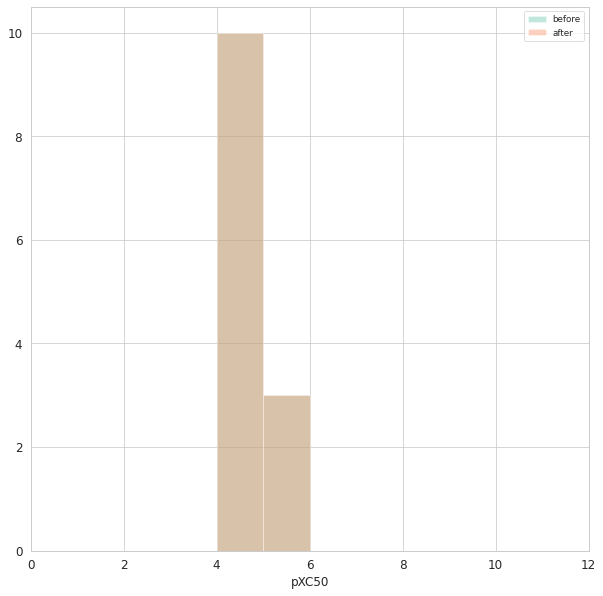

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()


before=dset_dtc["pXC50"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["pXC50"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])

# CHEMBL Curation

In [80]:
chembl = chembl.drop(columns=chembl.iloc[:,0:1])
chembl

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
0,CHEMBL12587,MUSCARINE,0.0,174.26,0.0,0.23,SID11111401,C[C@@H]1O[C@H](C[N+](C)(C)C)C[C@H]1O,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,NaN,C[C@@H]1O[C@H](C[N+](C)(C)C)C[C@H]1O
1,CHEMBL1367367,NaN,0.0,285.14,0.0,2.65,SID4254406,COc1ccc(Br)c2c1C[C@H](C(=O)O)CC2,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,NaN,COc1ccc(Br)c2c1C[C@H](C(=O)O)CC2
2,CHEMBL1449599,NaN,0.0,416.50,0.0,1.82,SID860315,CCn1cc(C(=O)NCC2CCCO2)c(=O)c2cc(F)c(N3CCN(C)CC...,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,NaN,CCn1cc(C(=O)NCC2CCCO2)c(=O)c2cc(F)c(N3CCN(C)CC...
3,CHEMBL1448712,NaN,0.0,353.37,0.0,-0.74,SID26751416,CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,NaN,CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...
4,CHEMBL1356101,NaN,0.0,261.29,0.0,-0.13,SID4239138,Cc1nc2cnc(N3CCOCC3)nc2n(C)c1=O,AC50,NaN,NaN,NaN,NaN,NaN,inactive,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,NaN,Cc1nc2cnc(N3CCOCC3)nc2n(C)c1=O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29856,CHEMBL2324405,NaN,0.0,499.38,1.0,5.58,18,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,IC50,'=',37.0,nM,7.43,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4040133,Inhibition of CYP2C9 (unknown origin),A,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL4038312,1.0,Scientific Literature,J Med Chem,2017.0,NaN,NaN,37.0,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...
29857,CHEMBL3234863,NaN,0.0,479.54,1.0,5.33,13i,C[C@H](c1ccccc1)N1C(=O)O[C@](Cc2ccccc2)(c2nnc(...,IC50,'>',19000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL3241727,Inhibition of CYP2C9 (unknown origin),A,BAO_0000357,single protein format,Homo sapiens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3397,Cytochrome P450 2C9,Homo sapiens,SINGLE PROTEIN,CHEMBL3232811,1.0,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.

In [81]:

chembl.columns = chembl.columns.str.lower()

In [82]:
new_chembl = chembl[['molecule_chembl_id','smiles', 'standard_type', 'standard_relation', 'standard_value',
              'standard_units', 'pchembl_value','base_rdkit_smiles','molecular_weight']]
new_chembl

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles,molecular_weight
0,CHEMBL12587,C[C@@H]1O[C@H](C[N+](C)(C)C)C[C@H]1O,AC50,NaN,NaN,NaN,NaN,C[C@@H]1O[C@H](C[N+](C)(C)C)C[C@H]1O,174.26
1,CHEMBL1367367,COc1ccc(Br)c2c1C[C@H](C(=O)O)CC2,AC50,NaN,NaN,NaN,NaN,COc1ccc(Br)c2c1C[C@H](C(=O)O)CC2,285.14
2,CHEMBL1449599,CCn1cc(C(=O)NCC2CCCO2)c(=O)c2cc(F)c(N3CCN(C)CC...,AC50,NaN,NaN,NaN,NaN,CCn1cc(C(=O)NCC2CCCO2)c(=O)c2cc(F)c(N3CCN(C)CC...,416.50
3,CHEMBL1448712,CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...,AC50,NaN,NaN,NaN,NaN,CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...,353.37
4,CHEMBL1356101,Cc1nc2cnc(N3CCOCC3)nc2n(C)c1=O,AC50,NaN,NaN,NaN,NaN,Cc1nc2cnc(N3CCOCC3)nc2n(C)c1=O,261.29
...,...,...,...,...,...,...,...,...,...
29856,CHEMBL2324405,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,IC50,'=',37.0,nM,7.43,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,499.38
29857,CHEMBL3234863,C[C@H](c1ccccc1)N1C(=O)O[C@](Cc2ccccc2)(c2nnc(...,IC50,'>',19000.0,nM,NaN,C[C@H](c1ccccc1)N1C(=O)O[C@](Cc2ccccc2)(c2nnc(...,479.54
29858,CHEMBL505,CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1,FC,'=',1.0,NaN,NaN,CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1,274.80
29859,CHEMBL4537998,O=C(Nc1ccc(Oc2ccc(F)cc2)cc1)N1CCc2ncccc2[C@@H]...,IC50,'=',4400.0,nM,5.36,O=C(Nc1ccc(Oc2ccc(F)cc2)cc1)N1CCc2ncccc2[C@@H]...,473.94


(array([3.9010e+03, 2.2021e+04, 3.5790e+03, 2.9500e+02, 1.9000e+01,
        2.0000e+01, 1.3000e+01, 1.1000e+01, 0.0000e+00, 2.0000e+00]),
 array([  32.05 ,  258.542,  485.034,  711.526,  938.018, 1164.51 ,
        1391.002, 1617.494, 1843.986, 2070.478, 2296.97 ]),
 <a list of 10 Patch objects>)

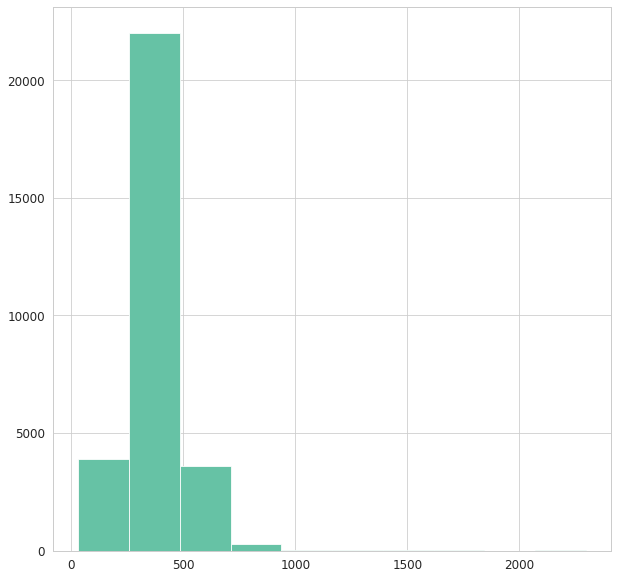

In [83]:
plt.hist(new_chembl.molecular_weight)

In [84]:

new_chembl.drop(index=new_chembl.loc[(new_chembl.molecular_weight>2000)].index)  # drop molecule weight >2000

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles,molecular_weight
0,CHEMBL12587,C[C@@H]1O[C@H](C[N+](C)(C)C)C[C@H]1O,AC50,NaN,NaN,NaN,NaN,C[C@@H]1O[C@H](C[N+](C)(C)C)C[C@H]1O,174.26
1,CHEMBL1367367,COc1ccc(Br)c2c1C[C@H](C(=O)O)CC2,AC50,NaN,NaN,NaN,NaN,COc1ccc(Br)c2c1C[C@H](C(=O)O)CC2,285.14
2,CHEMBL1449599,CCn1cc(C(=O)NCC2CCCO2)c(=O)c2cc(F)c(N3CCN(C)CC...,AC50,NaN,NaN,NaN,NaN,CCn1cc(C(=O)NCC2CCCO2)c(=O)c2cc(F)c(N3CCN(C)CC...,416.50
3,CHEMBL1448712,CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...,AC50,NaN,NaN,NaN,NaN,CCOC(=O)CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C...,353.37
4,CHEMBL1356101,Cc1nc2cnc(N3CCOCC3)nc2n(C)c1=O,AC50,NaN,NaN,NaN,NaN,Cc1nc2cnc(N3CCOCC3)nc2n(C)c1=O,261.29
...,...,...,...,...,...,...,...,...,...
29856,CHEMBL2324405,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,IC50,'=',37.0,nM,7.43,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,499.38
29857,CHEMBL3234863,C[C@H](c1ccccc1)N1C(=O)O[C@](Cc2ccccc2)(c2nnc(...,IC50,'>',19000.0,nM,NaN,C[C@H](c1ccccc1)N1C(=O)O[C@](Cc2ccccc2)(c2nnc(...,479.54
29858,CHEMBL505,CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1,FC,'=',1.0,NaN,NaN,CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1,274.80
29859,CHEMBL4537998,O=C(Nc1ccc(Oc2ccc(F)cc2)cc1)N1CCc2ncccc2[C@@H]...,IC50,'=',4400.0,nM,5.36,O=C(Nc1ccc(Oc2ccc(F)cc2)cc1)N1CCc2ncccc2[C@@H]...,473.94


In [85]:
print(sum(new_chembl['pchembl_value'].isna()) )
print(len(new_chembl) - sum(new_chembl['pchembl_value'].isna()))

len(chembl)

17189
12672


29861

In [86]:
dset_chembl = new_chembl[~(new_chembl.molecule_chembl_id.isna())  &
            (new_chembl.standard_units == 'nM') &
            ~new_chembl.standard_value.isna() &
             (new_chembl.standard_relation == "'='" ) &
             ~new_chembl.standard_relation.isna()&
             ~new_chembl.pchembl_value.isna()]

In [87]:
dset_chembl = dset_chembl.loc[(new_chembl.standard_type == 'IC50') | (new_chembl.standard_type == 'EC50')]
dset_chembl

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,pchembl_value,base_rdkit_smiles,molecular_weight
42,CHEMBL4472858,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncc3F)cc2)c1,IC50,'=',7700.0,nM,5.11,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncc3F)cc2)c1,350.39
47,CHEMBL464234,C[C@H]1CN(S(=O)(=O)C[C@]23CC[C@H](C[C@@H]2O)C3...,IC50,'=',4000.0,nM,5.40,C[C@H]1CN(S(=O)(=O)C[C@]23CC[C@H](C[C@@H]2O)C3...,479.54
48,CHEMBL3699082,OC(Cn1cnnc1)(c1ccc(F)cc1F)C(F)(F)c1cnc2cc(Cl)c...,IC50,'=',42000.0,nM,4.38,OC(Cn1cnnc1)(c1ccc(F)cc1F)C(F)(F)c1cnc2cc(Cl)c...,437.78
49,CHEMBL3664718,CC(C)n1cc(-c2ccc([C@H](C)N3CC[C@](CC(C)(C)O)(c...,IC50,'=',17700.0,nM,4.75,CC(C)n1cc(-c2ccc([C@H](C)N3CC[C@](CC(C)(C)O)(c...,488.63
62,CHEMBL3408957,CC(C)N1CCC(Oc2ccc(/C=C/c3n[nH]c4cc([C@@H]5C[C@...,IC50,'=',2400.0,nM,5.62,CC(C)N1CCC(Oc2ccc(/C=C/c3n[nH]c4cc([C@@H]5C[C@...,518.66
...,...,...,...,...,...,...,...,...,...
29849,CHEMBL4062697,Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2cc(F)ccn2)n1,IC50,'=',5700.0,nM,5.24,Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2cc(F)ccn2)n1,342.31
29850,CHEMBL4096818,Cc1cc(Oc2cncc(Cl)c2)cc(C(=O)Nc2ccc(F)cn2)n1,IC50,'=',21500.0,nM,4.67,Cc1cc(Oc2cncc(Cl)c2)cc(C(=O)Nc2ccc(F)cn2)n1,358.76
29854,CHEMBL4168669,Cl.Cl.NCc1ccc(-c2cnccc2-c2ccco2)s1,IC50,'=',4400.0,nM,5.36,NCc1ccc(-c2cnccc2-c2ccco2)s1,329.25
29856,CHEMBL2324405,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,IC50,'=',37.0,nM,7.43,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,499.38


In [88]:
sum(new_chembl.base_rdkit_smiles.isna())

0

In [89]:
dset_chembl.to_csv('drive/MyDrive/E4511-2021-Fan/CHEMBL_DROP.csv')

In [90]:
dp.diversity_plots(dset_key = 'drive/MyDrive/E4511-2021-Fan/CHEMBL_DROP.csv',
                   datastore = False,
                   response_col = 'pchembl_value', smiles_col='base_rdkit_smiles',id_col='molecule_chembl_id',
                   max_for_mcs = 100)

Canonicalizing 2059 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


AttributeError: ignored

In [92]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = dset_chembl['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

print(len(dist_sample))
print(len(smiles_lst1))

2222
2222


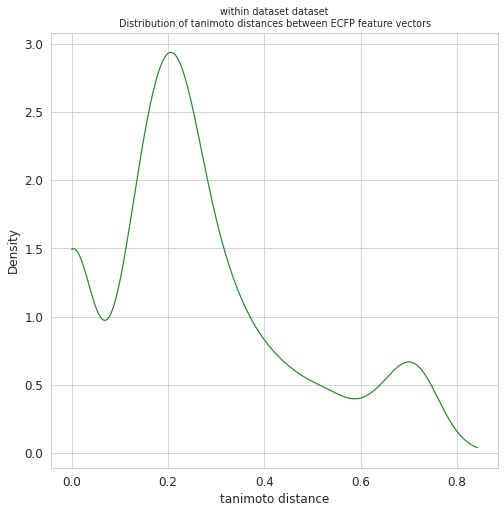

In [93]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')

In [94]:
dset_chembl=dset_chembl.rename(columns={'pchembl_value':'PXC50'})
dset_chembl

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,PXC50,base_rdkit_smiles,molecular_weight
42,CHEMBL4472858,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncc3F)cc2)c1,IC50,'=',7700.0,nM,5.11,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncc3F)cc2)c1,350.39
47,CHEMBL464234,C[C@H]1CN(S(=O)(=O)C[C@]23CC[C@H](C[C@@H]2O)C3...,IC50,'=',4000.0,nM,5.40,C[C@H]1CN(S(=O)(=O)C[C@]23CC[C@H](C[C@@H]2O)C3...,479.54
48,CHEMBL3699082,OC(Cn1cnnc1)(c1ccc(F)cc1F)C(F)(F)c1cnc2cc(Cl)c...,IC50,'=',42000.0,nM,4.38,OC(Cn1cnnc1)(c1ccc(F)cc1F)C(F)(F)c1cnc2cc(Cl)c...,437.78
49,CHEMBL3664718,CC(C)n1cc(-c2ccc([C@H](C)N3CC[C@](CC(C)(C)O)(c...,IC50,'=',17700.0,nM,4.75,CC(C)n1cc(-c2ccc([C@H](C)N3CC[C@](CC(C)(C)O)(c...,488.63
62,CHEMBL3408957,CC(C)N1CCC(Oc2ccc(/C=C/c3n[nH]c4cc([C@@H]5C[C@...,IC50,'=',2400.0,nM,5.62,CC(C)N1CCC(Oc2ccc(/C=C/c3n[nH]c4cc([C@@H]5C[C@...,518.66
...,...,...,...,...,...,...,...,...,...
29849,CHEMBL4062697,Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2cc(F)ccn2)n1,IC50,'=',5700.0,nM,5.24,Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2cc(F)ccn2)n1,342.31
29850,CHEMBL4096818,Cc1cc(Oc2cncc(Cl)c2)cc(C(=O)Nc2ccc(F)cn2)n1,IC50,'=',21500.0,nM,4.67,Cc1cc(Oc2cncc(Cl)c2)cc(C(=O)Nc2ccc(F)cn2)n1,358.76
29854,CHEMBL4168669,Cl.Cl.NCc1ccc(-c2cnccc2-c2ccco2)s1,IC50,'=',4400.0,nM,5.36,NCc1ccc(-c2cnccc2-c2ccco2)s1,329.25
29856,CHEMBL2324405,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,IC50,'=',37.0,nM,7.43,Cn1nccc1-c1cc(Cl)ccc1Oc1cc(F)c(S(=O)(=O)Nc2csc...,499.38


In [95]:
import os

# From our dataframe, we are working with the PIC50 column 
data=dset_chembl

column = 'PXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'molecule_chembl_id'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# Here we are creating a new dataframe, called check_df
check_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (2220, 13)
List of 'bad' duplicates removed
     molecule_chembl_id  PXC50  VALUE_NUM_mean  Perc_Var  VALUE_NUM_std
1309      CHEMBL3260358   5.32            6.24  14.74359       1.301076
1848      CHEMBL3260358   7.16            6.24  14.74359       1.301076

Dataset de-duplicated
Dataframe size (2058, 13)
New column created with averaged values:  VALUE_NUM_mean


In [96]:

old_compound_id='base_rdkit_smiles'
new_compound_id='base_rdkit_smiles'

# Takes all the compounds that aren't part of the curated data frame and prints them
reject=data[~data[old_compound_id].isin(check_df[new_compound_id])]
reject

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units,PXC50,base_rdkit_smiles,molecular_weight
18144,CHEMBL3260358,O=C(NCc1ccc(S(=O)(=O)c2cccc(C(F)(F)F)c2)cc1)c1...,IC50,'=',4800.0,nM,5.32,O=C(NCc1ccc(S(=O)(=O)c2cccc(C(F)(F)F)c2)cc1)c1...,460.44
25124,CHEMBL3260358,O=C(NCc1ccc(S(=O)(=O)c2cccc(C(F)(F)F)c2)cc1)c1...,IC50,'=',70.0,nM,7.16,O=C(NCc1ccc(S(=O)(=O)c2cccc(C(F)(F)F)c2)cc1)c1...,460.44


In [97]:
column='PXC50'; #'standard_value'
list_bad_duplicates='Yes'

# Actually compiles all the data with the specifies column and tells what columns to include 
# (inchi_key, smiles, and relation)
temp_df=curate_data.aggregate_assay_data(data, 
                                         value_col=column, 
                                         output_value_col=None,
                                         label_actives=True,
                                         active_thresh=6,
                                         id_col='molecule_chembl_id', 
                                         smiles_col='base_rdkit_smiles', 
                                         relation_col='standard_relation')

#Removes all duplicates from the data frame and puts it in the final, curated dataframe
curated_df = temp_df[~temp_df.isin([np.inf]).any(1)]

0 entries in input table are missing SMILES strings
2059 unique SMILES strings are reduced to 2058 unique base SMILES strings


In [98]:
curated_df.to_csv('drive/MyDrive/E4511-2021-Fan/CHEMBL_curated.csv')

In [99]:

# Prints number of unique resjected compound names/rows
print("Number of discarded compounds",reject[compound_id].nunique())

Number of discarded compounds 1


(0.0, 12.0)

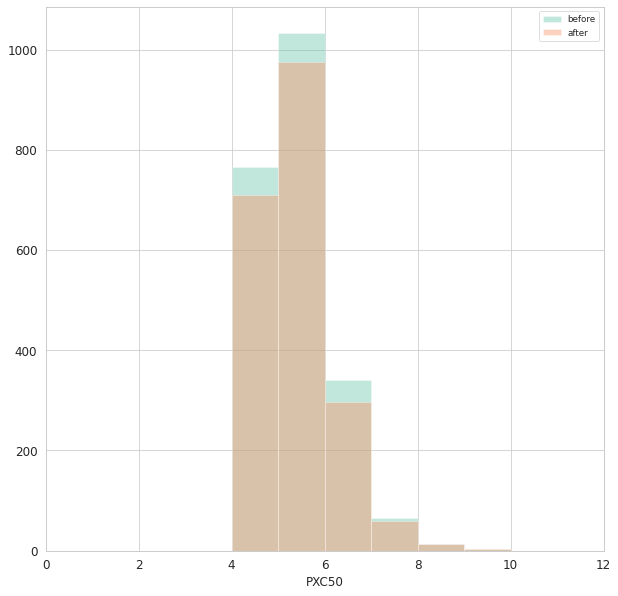

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()


before=dset_chembl["PXC50"]

# Our after variable is comprised of our curated_df dataframe 
# Our curated_df was configured earlier to discard any out of range values
after=curated_df["PXC50"]

# plots the values of the response value column of both the before and after dataframes from above
# sns.distplot is a Seaborn distplot, which allows you to show a histogram with a line on it
# A distplot plots a univariate distribution of observations 
# Below, we are separating our data set into a before section and an after section 
# To break down the sns.distplot functions: 
# bins=range(0, 12, 1) is used to bin our range of values, meaning to divide the entire range of values into a series of intervals
# ax=ax 
# kde is a kernel density estimate plot that represents the data using a continuous probability density curve
# kde=False will remove the density line on the histogram
# The label= function is used to label different sections of our plot 
sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')

#configures plot by adding a legend and setting the x axis limits for readability
# plt.legend() adds the legend to the plot
plt.legend()

# ax.set_xlim is setting the x-axis limits of the graph, setting it to be from (0,12)
ax.set_xlim([0, 12])

# EXCAPE Curation

In [101]:
excape=excape.drop(columns=excape.iloc[:,0:1])
excape

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
0,KBHRJXPYHVQCCB-UHFFFAOYNA-N,660057,1559,N,NaN,pubchem_screening,777,9606,CYP2C9,un28,O1CCN(CC1)CC#CCOCCO,OCCOCC#CCN1CCOCC1
1,PFNFFQXMRSDOHW-UHFFFAOYNA-N,1103,1559,N,NaN,pubchem,883,9606,CYP2C9,un28,N(CCCCNCCCN)CCCN,NCCCNCCCCNCCCN
2,STHIZMRUXPMSCW-UHFFFAOYNA-N,123435,1559,N,NaN,pubchem_screening,777,9606,CYP2C9,un28,O1CCNCCOCCOCCNCC1,C1COCCNCCOCCOCCN1
3,XVFVMXHZBURBPL-UHFFFAOYNA-N,3245471,1559,N,NaN,pubchem_screening,777,9606,CYP2C9,un28,O=C1N(CN2CCCCC2)CCC1,O=C1CCCN1CN1CCCCC1
4,AEUTYOVWOVBAKS-UHFFFAOYNA-N,3279,1559,N,NaN,pubchem_screening,777,9606,CYP2C9,un28,OCC(NCCNC(CC)CO)CC,CCC(CO)NCCNC(CC)CO
...,...,...,...,...,...,...,...,...,...,...,...,...
85286,KTXLOLYTPHILEU-QWOVJGMINA-N,5307254,1559,N,NaN,pubchem_screening,777,9606,CYP2C9,un28,S=1(O)C2=C(N(CC3=CC=CC=C3)C(=O)C1)C=C(C=C2)C(=...,CCOCCCNC(=O)c1ccc2c(c1)N(Cc1ccccc1)C(=O)C=S2O
85287,KUIRJFQCMORRRL-MRSUPTMINA-N,CHEMBL1358137,1559,A,5.1,chembl20,737826,9606,CYP2C9,un28,S(C=1N=C(N=C2N(C=NC21)CC(C)C)N)CC3=C4C(=CC=C3C...,Cc1ccc2ccccc2c1CSc1nc(N)nc2c1ncn2CC(C)C
85288,KUIWUUMOEBUQAF-PKSOQXRJNA-N,1637762,1559,N,NaN,pubchem_screening,777,9606,CYP2C9,un28,S1C(NC(=O)CN2C(=O)C=3C(C2=O)=CC=CC3)=NC(C4=CC(...,O=C(CN1C(=O)c2ccccc2C1=O)Nc1nc(-c2cccc([N+](=O...
85289,KULMHSMWESJHIA-PKSOQXRJNA-N,2931318,1559,N,NaN,pubchem_screening,1024,9606,CYP2C9,un28,O1CCN(CC1)C=2N=C(N3CCN(CC3)C4=CC=C(OC)C=C4)N=C...,COc1ccc(N2CCN(c3nc(NCCO)nc(N4CCOCC4)n3)CC2)cc1


In [102]:

print(sum(excape['pXC50'].isna()) )
print(len(excape) - sum(excape['pXC50'].isna()))
# it is probably not a good idea if i have 100k of empty value for pXC50
len(excape)

79249
6042


85291

Load target data into a pandas data frame

In [105]:
save_df = excape
save_df = save_df[save_df['pXC50'].notna()]
len(save_df)
sum(save_df['base_rdkit_smiles'].isna()) # there is no empty rdkit smiles

0

In [106]:
save_df.to_csv('drive/MyDrive/E4511-2021-Fan/EXCAPE_DROP.csv')

In [107]:
save_smiles_df = save_df
save_smiles_df_copy = save_smiles_df
save_smiles_df = save_smiles_df.sample(frac=0.5, random_state=1)

In [108]:
## We need to save this format with the RDKIT conanonical SMILES
save_smiles_df.to_csv("drive/MyDrive/E4511-2021-Fan/frac_excape.csv",index=False)

Post-processing dataset

Total Number of results = 3021
dataset mean = 5.265304078119814 NM
dataset stdev = 0.6942961615394369 NM
dataset max = 8.8 NM
dataset min = 3.67 NM



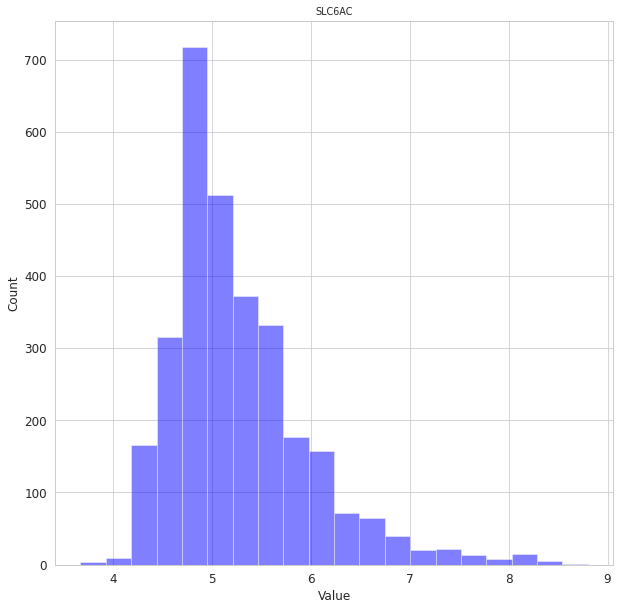

In [109]:
# Our outcome is pXC50 
column = 'pXC50'

# num_bins wil decide how many bins for creating histogram plot
num_bins = 20

target_name = 'SLC6AC'
# Ue the target_name as the title for the plot 
title = target_name

# Outcome data units (nanomolar = nm = $1 x 10^-9$ M )
units = 'NM'

# filepath, in this case, current dir
filepath = ""

# save_smiles_df was defined earlier
data=save_smiles_df

# call AMPL function (mouse over the function call and view source to see the code)
# The curate_data.summarize_data will summarize the data 
# output will be: 
# Total Number of results (data rows)
#   dataset mean: (mean of pXC50)
#   dataset stdev: (sd of pXC50)
#   dataset max: max value of data
#   dataset min: min value of data
curate_data.summarize_data(column, num_bins, title, units, filepath, data)

In [110]:

data.rename( columns={ "Ambit_InchiKey" : "compound_id" }, inplace=True)

curated_file = "frac_excape.csv"
data.head(5)

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
67594,XWYBIEFHCISIRV-UHFFFAOYNA-N,CHEMBL1513241,1559,A,6.20,chembl20,737826,9606,CYP2C9,un28,O=C1N(C=2N=C(N=CC2N=C1C3=CC(=CC=C3)C#N)N4CCNCC...,N#Cc1cccc(-c2nc3cnc(N4CCNCC4)nc3n(C3CC3)c2=O)c1
7384,BQPCBRFOSWMALO-RVLWREAZNA-N,CHEMBL103313,1559,A,5.06,chembl20,51546,9606,CYP2C9,un28,N(=C/NC1=CC=C(C=C1)CCCC)\O,CCCCc1ccc(N/C=N/O)cc1
46762,OMXGISKMOCGINK-GPQMBLKYNA-N,CHEMBL1427186,1559,N,4.70,chembl20,737826,9606,CYP2C9,un28,ClC1=C(C=2OC(=C(N2)CSCC(=O)NC3CC3)C)C=CC=C1,Cc1oc(-c2ccccc2Cl)nc1CSCC(=O)NC1CC1
76011,RAOGUIYRSFJVCY-LILDFLRNNA-N,CHEMBL1313862,1559,N,4.60,chembl20,737826,9606,CYP2C9,un28,S(C1=NN2C(=NN=C2C=C1)C=3C=CC(F)=CC3)CC(=O)NC4=...,Cc1cc(NC(=O)CSc2ccc3nnc(-c4ccc(F)cc4)n3n2)no1
54545,AFIBHUSAXJIJHX-MPIMZMORNA-N,CHEMBL1480806,1559,A,6.10,chembl20,737826,9606,CYP2C9,un28,ClC1=C(C=2C=C3C(N=CN=C3NCC4=CN=CC=C4)=CC2)C=CC=C1,Clc1ccccc1-c1ccc2ncnc(NCc3cccnc3)c2c1


In [111]:
# column: Response values column
column = 'pXC50'

# tolerance: Percentage of individual respsonse values allowed to different from 
# the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 1

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'base_rdkit_smiles'

# column that will be averaged ; smiles_col; used to find the replicates
# 

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, 
                                                       list_bad_duplicates, 
                                                       data, max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)
# curated_file = os.path.join(working_dir, ofile)
## discard out of range values
curated_df=curated_df[curated_df['VALUE_NUM_mean']>2]
curated_df.to_csv(curated_file, index=False)
curated_df.head()

Bad duplicates removed from dataset
Dataframe size (3021, 16)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, pXC50, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (3020, 16)
New column created with averaged values:  VALUE_NUM_mean


,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,XWYBIEFHCISIRV-UHFFFAOYNA-N,CHEMBL1513241,1559,A,6.20,chembl20,737826,9606,CYP2C9,un28,O=C1N(C=2N=C(N=CC2N=C1C3=CC(=CC=C3)C#N)N4CCNCC...,N#Cc1cccc(-c2nc3cnc(N4CCNCC4)nc3n(C3CC3)c2=O)c1,6.20,NaN,0.0,0
1,BQPCBRFOSWMALO-RVLWREAZNA-N,CHEMBL103313,1559,A,5.06,chembl20,51546,9606,CYP2C9,un28,N(=C/NC1=CC=C(C=C1)CCCC)\O,CCCCc1ccc(N/C=N/O)cc1,5.06,NaN,0.0,0
2,OMXGISKMOCGINK-GPQMBLKYNA-N,CHEMBL1427186,1559,N,4.70,chembl20,737826,9606,CYP2C9,un28,ClC1=C(C=2OC(=C(N2)CSCC(=O)NC3CC3)C)C=CC=C1,Cc1oc(-c2ccccc2Cl)nc1CSCC(=O)NC1CC1,4.70,NaN,0.0,0
3,RAOGUIYRSFJVCY-LILDFLRNNA-N,CHEMBL1313862,1559,N,4.60,chembl20,737826,9606,CYP2C9,un28,S(C1=NN2C(=NN=C2C=C1)C=3C=CC(F)=CC3)CC(=O)NC4=...,Cc1cc(NC(=O)CSc2ccc3nnc(-c4ccc(F)cc4)n3n2)no1,4.60,NaN,0.0,0
4,AFIBHUSAXJIJHX-MPIMZMORNA-N,CHEMBL1480806,1559,A,6.10,chembl20,737826,9606,CYP2C9,un28,ClC1=C(C=2C=C3C(N=CN=C3NCC4=CN=CC=C4)=CC2)C=CC=C1,Clc1ccccc1-c1ccc2ncnc(NCc3cccnc3)c2c1,6.10,NaN,0.0,0


In [112]:
curated_df

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,XWYBIEFHCISIRV-UHFFFAOYNA-N,CHEMBL1513241,1559,A,6.20,chembl20,737826,9606,CYP2C9,un28,O=C1N(C=2N=C(N=CC2N=C1C3=CC(=CC=C3)C#N)N4CCNCC...,N#Cc1cccc(-c2nc3cnc(N4CCNCC4)nc3n(C3CC3)c2=O)c1,6.20,NaN,0.0,0
1,BQPCBRFOSWMALO-RVLWREAZNA-N,CHEMBL103313,1559,A,5.06,chembl20,51546,9606,CYP2C9,un28,N(=C/NC1=CC=C(C=C1)CCCC)\O,CCCCc1ccc(N/C=N/O)cc1,5.06,NaN,0.0,0
2,OMXGISKMOCGINK-GPQMBLKYNA-N,CHEMBL1427186,1559,N,4.70,chembl20,737826,9606,CYP2C9,un28,ClC1=C(C=2OC(=C(N2)CSCC(=O)NC3CC3)C)C=CC=C1,Cc1oc(-c2ccccc2Cl)nc1CSCC(=O)NC1CC1,4.70,NaN,0.0,0
3,RAOGUIYRSFJVCY-LILDFLRNNA-N,CHEMBL1313862,1559,N,4.60,chembl20,737826,9606,CYP2C9,un28,S(C1=NN2C(=NN=C2C=C1)C=3C=CC(F)=CC3)CC(=O)NC4=...,Cc1cc(NC(=O)CSc2ccc3nnc(-c4ccc(F)cc4)n3n2)no1,4.60,NaN,0.0,0
4,AFIBHUSAXJIJHX-MPIMZMORNA-N,CHEMBL1480806,1559,A,6.10,chembl20,737826,9606,CYP2C9,un28,ClC1=C(C=2C=C3C(N=CN=C3NCC4=CN=CC=C4)=CC2)C=CC=C1,Clc1ccccc1-c1ccc2ncnc(NCc3cccnc3)c2c1,6.10,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,PSAZTHHVWMHDLU-UHFFFAOYNA-N,CHEMBL1382735,1559,N,4.95,chembl20,737826,9606,CYP2C9,un28,S(=O)(=O)(C1=NC(=NC(N2CCOCC2)=C1)C3=CC=CC=C3)C...,Cc1ccc(S(=O)(=O)c2cc(N3CCOCC3)nc(-c3ccccc3)n2)cc1,4.95,NaN,0.0,0
3017,JBCMRQFLVJQMFH-UHFFFAOYNA-N,CHEMBL1443332,1559,N,4.85,chembl20,737826,9606,CYP2C9,un28,N1(C(C=2N(N=NN2)C3CCCC3)C4=CC=5C(=NC=CC5)C=C4)...,c1cnc2ccc(C(c3nnnn3C3CCCC3)N3CCN4CCCC4C3)cc2c1,4.85,NaN,0.0,0
3018,ZHXBCPSYEAQEHB-OFLQKSSCNA-N,CHEMBL434119,1559,N,4.40,chembl20,737826,9606,CYP2C9,un28,[C@@H]([C@H](C(O)=O)N)(CC(O)=O)C=1C=CC(=CC1)Cl,N[C@@H](C(=O)O)[C@H](CC(=O)O)c1ccc(Cl)cc1,4.40,NaN,0.0,0
3019,IMWIBCFLGGZQCV-UHFFFAOYNA-N,CHEMBL1485850,1559,N,4.80,chembl20,737826,9606,CYP2C9,un28,S1N=NC(C(=O)N2CCC3(CC2)CCN(CC3)C=4C=CN=CC4)=C1,O=C(c1csnn1)N1CCC2(CC1)CCN(c1ccncc1)CC2,4.80,NaN,0.0,0


In [113]:
curated_df['Remove_BadDuplicate'].value_counts()

0    3020
Name: Remove_BadDuplicate, dtype: int64

In [114]:
compound_id='base_rdkit_smiles'
reject=data[~data[compound_id].isin(curated_df[compound_id])]
reject # this is the rows we wanna discard

,compound_id,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles


In [115]:
print("Number of discarded compounds",reject[compound_id].nunique())
# ofile=tmp_dir+target_name+'.reject_check.'+username
ofile=target_name+'.reject_check.csv'
reject.to_csv(ofile,index=False)

Number of discarded compounds 0


(0.0, 12.0)

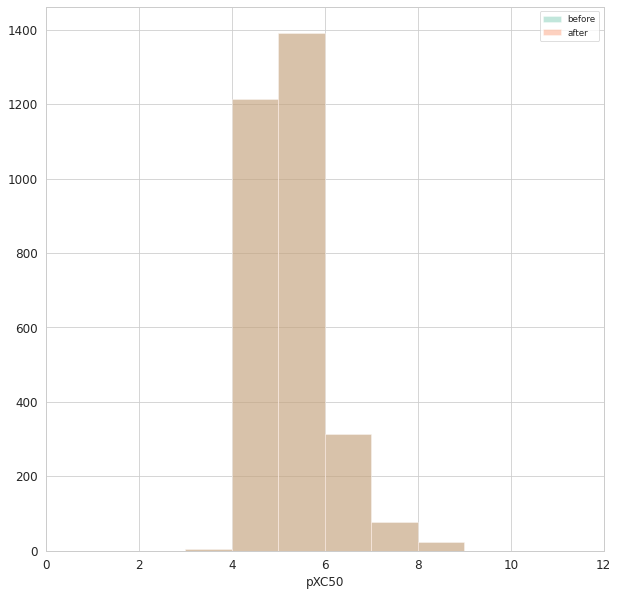

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()

# This will be our before curation
before=data["pXC50"]

# current curated dataframe will not include any out of range values
after=curated_df["pXC50"]

sns.distplot(before, bins=range(0, 12, 1), ax=ax, kde=False, label='before')
sns.distplot(after, bins=range(0, 12, 1), ax=ax, kde=False, label='after')
plt.legend()
ax.set_xlim([0, 12])

In [117]:
# ifile=tmp_dir+target_name+'_excape.csv.'+username
ifile="frac_excape.csv"

In [118]:
x_del = pd.read_csv(ifile)

In [119]:

x_del.columns

Index(['compound_id', 'Original_Entry_ID', 'Entrez_ID', 'Activity_Flag',
       'pXC50', 'DB', 'Original_Assay_ID', 'Tax_ID', 'Gene_Symbol',
       'Ortholog_Group', 'SMILES', 'base_rdkit_smiles', 'VALUE_NUM_mean',
       'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate'],
      dtype='object')

In [120]:
dp.diversity_plots(dset_key=ifile,datastore=False,id_col='compound_id',response_col='pXC50',smiles_col = 'base_rdkit_smiles')

Canonicalizing 3020 molecules...
Done
Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


AttributeError: ignored

In [121]:
feat_type = 'ECFP'
dist_metric = 'tanimoto'
smiles_lst1 = save_smiles_df['base_rdkit_smiles'].tolist()
calc_type = 'nearest'
dist_sample = cd.calc_dist_smiles(feat_type, dist_metric, smiles_lst1, None, calc_type)

In [122]:

print(len(dist_sample))
print(len(smiles_lst1))

3021
3021


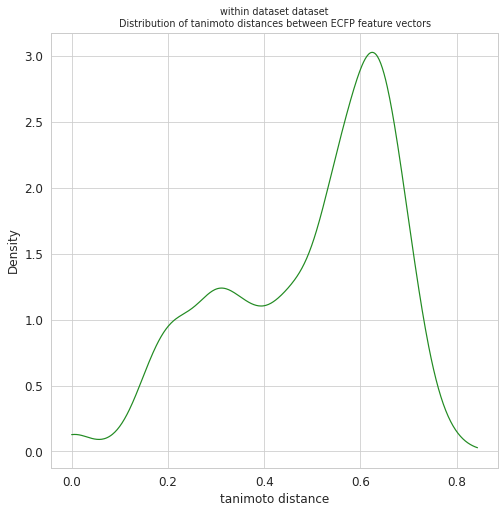

In [123]:
from scipy.stats.kde import gaussian_kde

# import math library
import numpy as np

# for creating plots
import matplotlib.pyplot as plt

# current directory
odir='./'

# name for the task
task_name='within dataset'

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
dist_pdf = gaussian_kde(dist_sample)
x_plt = np.linspace(min(dist_sample), max(dist_sample), 500)
y_plt = dist_pdf(x_plt)    
fig, ax = plt.subplots(figsize=(8.0,8.0))
ax.plot(x_plt, y_plt, color='forestgreen')
ax.set_xlabel('%s distance' % dist_metric)
ax.set_ylabel('Density')
ax.set_title("%s dataset\nDistribution of %s distances between %s feature vectors" % (
              task_name, dist_metric, feat_type))
fig.savefig(odir+'distance_to_background_mol.png')